# The user should input: the star's effective temperature (and uncertainty), the event ID (KIC ID), the index number and the max and min freq as seen by eye

In [15]:
Teff_star= 4972 #star's temp
Teff_star_uncertainty = 50   #uncertainty of temp

event_id = 'KIC 10001893'
cadence_condition = 'short'

b =2#index for tpf and lightcurve

#the index of the tpf and lightcurve. #change manually or implement a loop through every single value then put it in a table)

In [11]:
#importing relevant libraries (use conda install if you don't have them)

import lightkurve as lk
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
import matplotlib
plt.style.use(lk.MPLSTYLE)
matplotlib.rcParams['text.usetex'] = False
import scipy.optimize as op
import sympy as smp
from sympy import symbols
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import optimize

# Getting tpf and light curve for each quarter

In [7]:
search_result = lk.search_lightcurve(event_id,cadence=cadence_condition)
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 03,2009,Kepler,60,kplr010001893,0.0
1,Kepler Quarter 06,2010,Kepler,60,kplr010001893,0.0
2,Kepler Quarter 06,2010,Kepler,60,kplr010001893,0.0
3,Kepler Quarter 06,2010,Kepler,60,kplr010001893,0.0
4,Kepler Quarter 07,2010,Kepler,60,kplr010001893,0.0
5,Kepler Quarter 07,2010,Kepler,60,kplr010001893,0.0
...,...,...,...,...,...,...
29,Kepler Quarter 15,2012,Kepler,60,kplr010001893,0.0
30,Kepler Quarter 15,2013,Kepler,60,kplr010001893,0.0


array([<AxesSubplot:title={'center':'Target ID: 10001893, Cadence: 620560'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>,
       <AxesSubplot:title={'center':'Target ID: 10001893, Cadence: 661540'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>,
       <AxesSubplot:title={'center':'Target ID: 10001893, Cadence: 708280'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>],
      dtype=object)

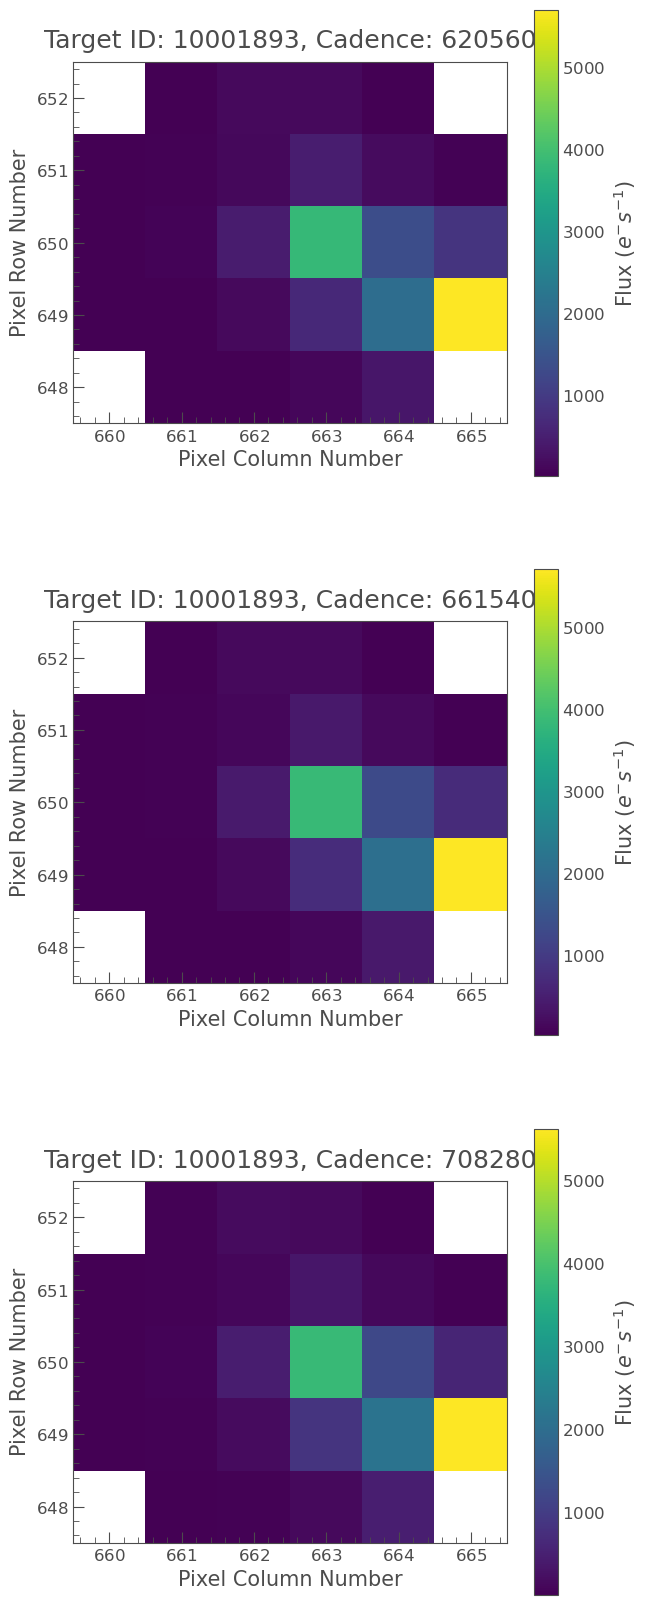

In [12]:
tpf = lk.search_targetpixelfile("KIC 10001893", author="Kepler", cadence='short',quarter=(6)).download_all(quality_bitmask="hard")
tpf.plot()






<AxesSubplot:title={'center':'Target ID: 10001893, Cadence: 708280'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

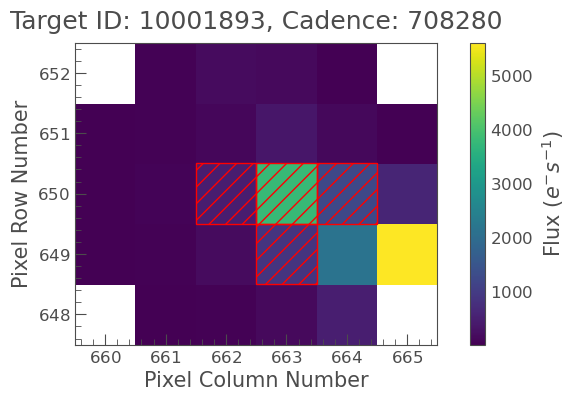

In [14]:
#Plotting the one we are considering
tpf[2].plot(aperture_mask='pipeline')

### in some cases, be sure you're not including a background star. 
#Some cutting method might need to be implemented depending on the star

In [10]:
type(tpf)

lightkurve.collections.TargetPixelFileCollection

In [16]:
#lc = tpf.to_lightcurve(aperture_mask="pipeline").remove_nans().remove_outliers()
#lc.normalize().plot()

lc = []
for m in range(len(tpf)):
    lc.append(tpf[m].to_lightcurve(aperture_mask="pipeline").remove_nans().remove_outliers())


In [12]:
#lc_collection = search_result.download_all()
#lc= lc_collection.stitch()

#not really necessary for 1 quarter. Need to stich for multiple quarters 

# Finding the zoom in region by eye (use all quarters for this part)

In [17]:
import warnings
warnings.filterwarnings('ignore')


In [21]:
lc_collection = search_result.download_all()
lc_stitched = lc_collection.stitch()
pg1 = lc_stitched.normalize(unit='ppm').to_periodogram(normalization='psd',minimum_frequency = 10**(-1),maximum_frequency=10**4)
pg1.plot(scale='log');



LightkurveError: Error in reading Data product /Users/sophiazhang/.lightkurve-cache/mastDownload/Kepler/kplr010001893_sc_Q000100333333333332/kplr010001893-2010355172524_slc.fits of type KeplerLightCurve .
This file may be corrupt due to an interrupted download. Please remove it from your disk and try again.

In [22]:
smooth_pg1 = pg1.smooth(method='logmedian', filter_width=0.1)
ax = pg1.plot(label='Original')
smooth_pg1.plot(ax=ax, linewidth=2,  color='red', label='Smoothed', scale='log');


NameError: name 'pg1' is not defined

# Defining all the functions

In [16]:
def ACF(power, frequency_spacing, numax):
    #Calculate a full width half maximum
    
    fwhm = int(np.floor(1.0 * 0.66 * numax**0.88 / frequency_spacing))
    fwhm -= fwhm % 2                                    # Make the FWHM value even (%2 = 0 if even, 1 if odd)

    x = int(numax / frequency_spacing)                  #Find the index value of numax
    s = np.hanning(len(snr.power[x-fwhm:x+fwhm]))   #Define the hanning window for the evaluated frequency space
    
    C = snr.power[x-fwhm:x+fwhm] * s                     #Multiply the evaluated SNR space by the hanning window
    #if len(C)!= 0:
    result = np.correlate(C, C, mode='full')
    return result[int(len(result)/2):]
    #else: 
        #pass #returns None (type None)

In [17]:
def max_acfspace(frequency_spacing, numaxs):
    maxval = numaxs.max()
    fwhm = int(np.floor(1.0 * 0.66 * maxval**0.88 / frequency_spacing))
    fwhm -= fwhm % 2
    return int(2*fwhm)

In [18]:
def fit_func(x, a, x0, sigma,m,c):
    gaus = a*np.exp(-(x-x0)**2/(2*sigma**2))
    line =m*x+c
    return gaus + line

In [20]:
from scipy.signal import find_peaks


def closest_value(input_list, input_value):
 
  arr = np.asarray(input_list)
 
  i = (np.abs(arr - input_value)).argmin()
 
  return arr[i]


In [21]:
## specifying the range of freq interested

freq_min = 100 

freq_max = 500

###### _________________________________________

# Automated loop

In [24]:
numax_calculated=[]
numax_calculated_uncertainty =[]
deltanu_calculated=[]
deltanu_calculated_uncertainty =[]
diagnostic_percentage_numax =[] #return the percentage
diagnostic_numax=[] #true or false
diagnostic_percentage_deltanu =[]
diagnostic_deltanu =[]

for e in range (len(tpf)):
    #creating periodogram --------
    pg = lc[b].to_periodogram(freq_unit = u.microhertz,normalization="psd",oversample_factor=10,minimum_frequency=freq_min,maximum_frequency=freq_max)
    snr = pg.flatten()
    frequency_spacing = np.median(np.diff(snr.frequency)).value

    # numax calculation ---------
    numaxs = np.exp(np.linspace(np.log(freq_min),np.log(freq_max),500)) #x axis of the frequency and max correlation graph 
    maxacf = np.zeros(len(numaxs))
    maxspace = max_acfspace(frequency_spacing, numaxs)
    ACF_list = np.zeros((len(numaxs),maxspace))
    power = snr.power.value
    for idx, numax in enumerate(numaxs):
        acf = ACF(power, frequency_spacing, numax)    #Calculate the ACF for a given numax
        ACF_list[idx,:len(acf)] = acf/len(acf)
        sum_acf = np.sum(ACF_list[idx,:len(acf)])
        maxacf[idx] = np.nanmax(acf) 
    ylim = int(10/frequency_spacing) #you can change the lag limit of the graph
    lags = np.linspace(0,ylim*frequency_spacing,ylim)
    xlim = int(numaxs.max()/frequency_spacing)
    best_numax = numaxs[np.argmax(maxacf)]     #The best numax is the numax that results in the highest ACF
    #Gaussian fitting ----------
    #estimate the initial condition
    a_guess = np.max(maxacf)
    x0_guess = np.mean(numaxs)
    sd_guess = np.std(numaxs)
    m_guess,c_guess = np.polyfit(numaxs,maxacf,1)
    popt, cov_phase = curve_fit(fit_func, numaxs, maxacf, p0 = [a_guess, x0_guess, sd_guess,m_guess,c_guess])
    
    #Calculating uncertainty
    x, a, mu, sigma, m, c= symbols('x, a, mu, sigma, m, c ')
    gaussian_plus_line  = a*smp.exp(-(x-mu)**2/(2*sigma**2))+ m*x+c
    derivative = smp.diff(gaussian_plus_line,x)
    eq1 = smp.Eq(derivative,0)
    numaxs_new = np.linspace(np.min(numaxs),np.max(numaxs),10000)
    numax_guess = numaxs_new[np.argmax(fit_func(numaxs_new, *popt))] 
    derivative_with_values = eq1.evalf(subs={a: popt[0] , mu: popt[1], 
                                                            
                                            sigma: popt[2], m: popt[3]})

    from sympy.utilities.lambdify import lambdify
    derivative_with_values_calculate = lambdify(x,derivative_with_values)

    numax_graph = op.fsolve(derivative_with_values_calculate,numax_guess)[0]
    numax_calculated.append(numax_graph) #put it into the numax array
    ###partial deriv -------
    partial_a = smp.idiff(derivative, x,a)
    partial_mu = smp.idiff(derivative, x,mu)
    partial_sigma = smp.idiff(derivative, x,sigma)
    partial_m = smp.idiff(derivative, x,m)
    # ------
    sigma_mu, sigma_a, sigma_sigma, sigma_m = symbols('sigma_mu, sigma_a, sigma_sigma, sigma_m')
    numax_uncertainty_expression = smp.sqrt(
    partial_a**2 * sigma_a**2 + partial_mu**2 * sigma_mu**2 + partial_sigma**2 * sigma_sigma**2
    +partial_m**2 * sigma_m**2)

    uncertainty = np.sqrt(np.diag(cov_phase)) #uncertainty of each fitting parameter via covariance matrix

    numax_uncertainty = numax_uncertainty_expression.evalf(subs={x: numax_graph ,a: popt[0] , mu: popt[1], 
                                                            
                                            sigma: popt[2], m: popt[3], 
                                            sigma_a: uncertainty[0], sigma_mu: uncertainty[1],
                                            sigma_sigma: uncertainty[2], sigma_m: uncertainty [3]}) 
    numax_calculated_uncertainty.append(numax_uncertainty) #append to the numax uncertainty array 
    
    # Diagnostic for numax -------
    threshold_accept = 0.05#we decide that the max difference between the values to be 5% (random)
    percentage_diff_max = np.abs(best_numax-(numax_graph+numax_uncertainty))/best_numax
    percentage_diff_min = np.abs(best_numax-(numax_graph-numax_uncertainty))/best_numax

    if percentage_diff_max<percentage_diff_min:
        percentage_diff = percentage_diff_max
    else: 
        percentage_diff = percentage_diff_min
    
    diagnostic_percentage_numax.append(percentage_diff) #appending % diff for numax
    
    if percentage_diff<threshold_accept:
        diagnostic_numax('Acceptable')
    else: 
        diagnostic_numax('Not acceptable')
        
    #deltanu stuff ----------
    
    numax = numax_graph

    fwhm = int(np.floor(1.0 * 0.25 * numax / frequency_spacing))
    fwhm -= fwhm % 2                                    # Make the FWHM value even (%2 = 0 if even, 1 if odd)
    
    x = int(numax / frequency_spacing)                  #Find the index value of numax
    s = np.hanning(len(snr.power[x-fwhm:x+fwhm]))   #Define the hanning window for the evaluated frequency space

    C = snr.power[x-fwhm:x+fwhm] * s                     #Multiply the evaluated SNR space by the hanning window
    result = np.correlate(C, C, mode='full')             #Correlated the resulting SNR space with itself
    acf = result[int(len(result)/2):]    
    
    c_1,c_2,v_max = symbols('c_1,c_2,v_max') 
    delta_nu_expression = c_1*v_max**c_2
    
    partial_c_1 = smp.diff(delta_nu_expression,c_1)
    partial_c_2 = smp.diff(delta_nu_expression, c_2)
    partial_v_max = smp.diff(delta_nu_expression, v_max)

    sigma_c_1, sigma_c_2, sigma_v_max = symbols('sigma_c_1, sigma_c_2, sigma_v_max')
    deltanu_uncertainty_expression = smp.sqrt(
    partial_c_1**2 * sigma_c_1**2 + partial_c_2*2 * sigma_c_2**2 + partial_v_max**2 * sigma_v_max**2)
    deltanu_uncertainty_2 = deltanu_uncertainty_expression.evalf(subs={
    c_1: 0.263, sigma_c_1: 0.009, c_2: 0.772 , sigma_c_2: 0.005, v_max: numax_graph, sigma_v_max: numax_uncertainty}) 
    float(deltanu_uncertainty_2)

    deltanu_empirical_average = 0.263*float(numax_graph)**(0.772)
    newlist_2 = np.linspace(deltanu_empirical_average-float(deltanu_uncertainty_2),
                        deltanu_empirical_average+float(deltanu_uncertainty_2),1000)
    
    peaks,_ = find_peaks(acf, prominence=(0, 10000),distance=3)


    deltanu_2=[]
    for f in range(len(newlist_2)):
        deltanu_2.append(closest_value(lags[peaks],newlist_2[f]))

    deltanu_mean_2 = np.mean(deltanu_2)
    deltanu_sd_2 = 0.5*(np.max(deltanu_2)-np.min(deltanu_2))
    
    deltanu_calculated.append(deltanu_mean_2)
    deltanu_calculated_uncertainty.append(deltanu_sd_2)
    
    if deltanu_sd_2/deltanu_mean_2<0.01:
        diagnostic_deltanu.append('Robust')
        diagnostic_percentage_deltanu.append(deltanu_sd_2/deltanu_mean_2 * 100)
    else:
        diagnostic_deltanu.append('Not robust')
        diagnostic_percentage_deltanu.append(deltanu_sd_2/deltanu_mean_2 * 100)

    

TypeError: 'list' object is not callable

In [ ]:
Teff_star= 4972 #star's temp
Teff_star_uncertainty = 50   #uncertainty of temp
numax_found, numax_uncertainty = numax_graph, numax_uncertainty
deltanu_found, deltanu_uncertainty = deltanu_mean_2, deltanu_sd_2
numax_solar = 3090
deltanu_solar = 135.1
Teff_solar = 5777.2

In [ ]:
mass=[]
mass_unc
for u in range(len(tpf)):
#calculating the mass
    mass_star = (numax_calculated/numax_solar)**3 * (deltanu_calculated/deltanu_solar)**(-4) *(Teff_star/Teff_solar)**1.5
#uncertainty of mass
    ratio1_relative_uncertainty = (numax_calculated_uncertainty/numax_calculated)*3
    ratio_2_relative_uncertainty = (deltanu_calculated_uncertainty/deltanu_calculated)*4
    ratio_3_relative_uncertainty = (Teff_star_uncertainty/Teff_star)*1.5

    total_relative_uncertainty = np.sqrt(ratio1_relative_uncertainty**2+ratio_2_relative_uncertainty**2+ratio_3_relative_uncertainty**2)
    mass_star_uncertainty = total_relative_uncertainty*mass_star

    print('the stellar mass is',round(mass_star,2),'±',round(mass_star_uncertainty,2),'solar mass')
    masss.append(mass_star)
    mass_unc